# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

from textblob import TextBlob

from sklearn import metrics
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
    classification_report,
    accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn import over_sampling

import pickle

import re
import string
from collections import Counter
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Reading the Data Set

In [2]:
# Mounting Google Colab drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PROJECT_PATH = '/content/drive/Othercomputers/My Computer/Upgrad/12 Deployment & Capstone/04 Capstone -Sentiment Based Product Recommendation System/sentiment_based_product_recommendation_system/'

df=pd.read_csv(PROJECT_PATH + 'dataset/sample30.csv')

pd.options.display.max_colwidth=1000
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


# Data Cleaning and Preprocessing

In [4]:
df.shape

(30000, 15)

In [5]:
df.dtypes

id                      object
brand                   object
categories              object
manufacturer            object
name                    object
reviews_date            object
reviews_didPurchase     object
reviews_doRecommend     object
reviews_rating           int64
reviews_text            object
reviews_title           object
reviews_userCity        object
reviews_userProvince    object
reviews_username        object
user_sentiment          object
dtype: object

In [6]:
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [7]:
# Replacing Null values with empty string as it can be managed by review text
df["reviews_title"].fillna("", inplace = True)

## Concatenate "Review Text" and "Review Title" Columns for better analysis

In [8]:
df["Reviews_Text_and_Title"] = df["reviews_text"] +" "+df["reviews_title"]

In [9]:
## Checking null values
df.isnull().sum()

id                            0
brand                         0
categories                    0
manufacturer                141
name                          0
reviews_date                 46
reviews_didPurchase       14068
reviews_doRecommend        2570
reviews_rating                0
reviews_text                  0
reviews_title                 0
reviews_userCity          28071
reviews_userProvince      29830
reviews_username             63
user_sentiment                1
Reviews_Text_and_Title        0
dtype: int64

## Removing unnecessary columns
Only id, name, reviews_rating, reviews_username, user_sentiment and Reviews_Text_and_Title columns are required for analysis

In [10]:
df = df[['id','name','reviews_rating','reviews_username','user_sentiment','Reviews_Text_and_Title']]

In [11]:
df.head()

,id,name,reviews_rating,reviews_username,user_sentiment,Reviews_Text_and_Title
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy. Just Awesome
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,Good flavor. This review was collected as part of a promotion. Good
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,Good flavor. Good
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca,Negative,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess. Disappointed"
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557,Negative,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel. Irritation


In [12]:
# Checking Null values
df.isnull().sum()

id                         0
name                       0
reviews_rating             0
reviews_username          63
user_sentiment             1
Reviews_Text_and_Title     0
dtype: int64

In [13]:
#Dropping Null rows as they are less than 1%
df.dropna(subset = ['user_sentiment','reviews_username'],inplace = True)

In [14]:
# Checking Null values
df.isnull().sum()

id                        0
name                      0
reviews_rating            0
reviews_username          0
user_sentiment            0
Reviews_Text_and_Title    0
dtype: int64

In [15]:
df.shape

(29936, 6)

# Text Processing

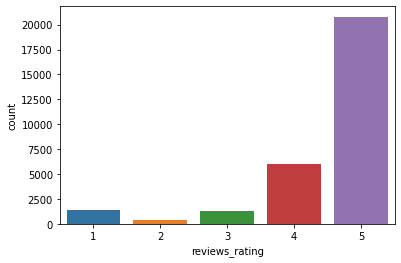

In [16]:
# Lets have a look at the frequency distribution of ratings

sns.countplot(data=df, x='reviews_rating')

In [17]:
df['user_sentiment'].value_counts()

Positive    26579
Negative     3357
Name: user_sentiment, dtype: int64

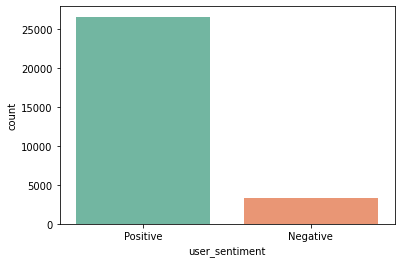

In [18]:
#Visualize user sentiment
sns.countplot(x='user_sentiment', data=df, palette="Set2")

**Analysis:** We can see overrepresentation of positive reviews. We may have to resolve Class Imbalance during modelling.

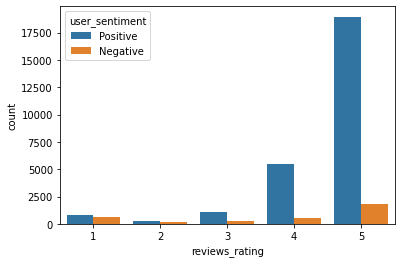

In [19]:
# Plotting User sentiments against the 5 ratings 

sns.countplot(df.reviews_rating, hue =df.user_sentiment)
plt.show()

In [20]:
pd.options.display.max_colwidth=1000
df.head()

,id,name,reviews_rating,reviews_username,user_sentiment,Reviews_Text_and_Title
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy. Just Awesome
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,Good flavor. This review was collected as part of a promotion. Good
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,Good flavor. Good
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca,Negative,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess. Disappointed"
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557,Negative,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel. Irritation


In [21]:
# Unique Products
df['name'].unique()

array(['Pink Friday: Roman Reloaded Re-Up (w/dvd)',
       'Lundberg Organic Cinnamon Toast Rice Cakes',
       'K-Y Love Sensuality Pleasure Gel',
       'J.R. Watkins Hand Cream, Lemon Cream',
       'Ambi Complexion Cleansing Bar',
       "Johnson's Baby Bubble Bath and Wash, 15oz",
       'Olay Regenerist Deep Hydration Regenerating Cream',
       'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
       'Heinz Tomato Ketchup, 38oz',
       'Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count',
       'Pantene Color Preserve Volume Shampoo, 25.4oz',
       'Aussie Aussome Volume Shampoo, 13.5 Oz',
       "Cars Toon: Mater's Tall Tales", 'CeraVe SA Renewing Cream',
       'Solo Foods Almond Paste',
       'Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count',
       'Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler',
       'Pearhead Id Bracelet Frame',
       'Craft Punch Giga Scallop Circle 45 24687534 To 334',
       'Neutrogena

In [22]:
df.user_sentiment.value_counts(normalize=True)

Positive    0.887861
Negative    0.112139
Name: user_sentiment, dtype: float64

In [23]:
# Mapping Negative to 0 and Positive to 1 

df['user_sentiment']= df.user_sentiment.apply(lambda x:1 if x == 'Positive' else 0 )

## Expand Contractions Dictionary of English Contractions
Contractions are the shortened versions of words like don’t for do not and how’ll for how will. These are used to reduce the speaking and writing time of words. We need to expand these contractions for a better analysis of the reviews.

In [24]:

contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['Reviews_Text_and_Title']=df['Reviews_Text_and_Title'].apply(lambda x:expand_contractions(x))


## Lowercase the reviews

In [25]:
df['cleaned']=df['Reviews_Text_and_Title'].apply(lambda x: x.lower())

## Remove digits and words containing digits

In [26]:
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

## Remove Punctuations

In [27]:
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

## Removing extra spaces

In [28]:
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [29]:
## This is how text looks after cleaning
for index,text in enumerate(df['cleaned'][35:40]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 i love this lotion nice and thick great fragrance i use it on my hands and my feet thick and works
Review 2:
 not sure how this works with clearing your complexion been using for weeks now but does keep your skin smooth and clean ok so far
Review 3:
 makes my skin feel clean and not super dry where its ashy if i dont follow with a moisturiser as soon as im done the skin doesnt feel oily or tacky makes my skin more radiant and use of foundation and concealer is not needed to make the skin look even and hydrated still works
Review 4:
 it makes my face feel nice and fresh after about days i did get slight acne but it cleared right back up will deff use this every day from now on ambi skincare
Review 5:
 i have used this soap for years and considered it walmart is best kept secret i was so disappointed when they stopped carrying it in our store location was delighted to see i could get it online it ended up a blessing i do not go to walmart as often so i am saving money there so

## Stopwords Removal  and lemmatizing the reviews

In [30]:
# Importing spacy
import spacy

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

## Group the reviews according to the products

In [31]:
df_grouped=df[['name','lemmatized']].groupby(by='name').agg(lambda x:' '.join(x))
df_grouped.head()

,lemmatized
name,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,latch flimsy remove key lock key flimsy slippery exterior include contour handle couple weight make difficult carry buy price right interior fair value great terrible unit open airedout weekly prevent condensation leave open hour month decompress water tight seal look store important file long time think forget high maintenance box heavy security box fire proof water proof hope condensation issue quality product wish key lock bit heavier tho nice size fire chest honeywell junk great product cost brand worth heavier well material better safe safe ship up fedex ship fedex office state little irony outstanding quality honeywell fire chest perfect size important document heavy difficult build sturdy need great product heavy big think work real notebook fit hang file folder information great good storage
100:Complete First Season (blu-Ray),unique scifi good premise bad futuristic shortcoming good plot shot america great character adolescent hard believe send try establish live earth old character bad well think series happen apocolapse interesting program decent science fiction television series worth watch good good cw enjoy story plot good season bit rocky typical teen drama past half pick season well go hill fast waste potential pleasant surprise engaging entertaining worth buy gr series interesting keep watch end great way catch series watch season great way catch like season great character story great entertaining watch good cast action enjoyable juvenile delinquent fight survival postapocalyptic world postapocalyptic tv series great quality wonderful customer service good price great great price like way watch summer like movie show well watch start slow end pretty good good tv show see year good bad scifi series especially cw story line kind dumb action love triangle hard straight wish well network like amc h...
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,monthly display open page give overall activity instantly writing space day memory jogger yearly planner seldom consult mark major moment year weeklymonthlyand quarterly display continuum page note phone address finger tip availablity fill need cumbersome fit briefcase pocket think room plan year easy lightweight month view faintly rule print appointment time clutter entry general note block month extra note page choice lot space big thin provide lot space information nice
"2x Ultra Era with Oxi Booster, 50fl oz",pretty good detergent reaction allergy product young girl remember mom era liquid detergent clothe detergent grease oil stain dad work uniform long day work diesel mechanic grow go college switch detergent roommate impressed result later life switch brand brand depend sale add powder oxiclean towel white clean recently store run era oxi booster laundry detergent get clothe clean leave smell fresh month later mom know work mom know best try expensive brand find come era fantastic pretreater stain remover great soap time forget pre treat clothe remember find worried clothe come clean time love product stain fighting smell price important have family budget thank era give awesome detergent need fabric softener wink wink best laundry detergent market variety product year return era truly give money worth great aspect laundry process cost lessbut clean better buy regardless cost claim product mother era finally realize era work stainspot treater real cleaning power family laundry great ...
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",table chair great easy great quality good quality


## Document Term Matrix

In [32]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped['lemmatized'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_grouped.index
df_dtm.head()

,aaa,aaaaaaaaaaaaaaaaa,aaaaahhhhhh,aaahhhhh,aaammmaaaze,aalot,aanyhwere,aaron,aarontaylor,ab,...,zombiemutantundead,zombies,zombifie,zone,zoo,zoom,zorbas,zucchetta,zucchini,zyrtec
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100:Complete First Season (blu-Ray),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"2x Ultra Era with Oxi Booster, 50fl oz",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Word Cloud

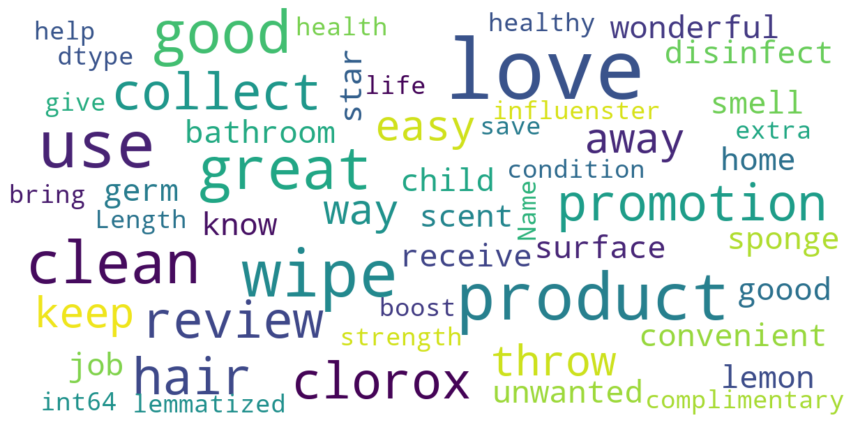

In [33]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud

# Transposing document term matrix
df_dtm=df_dtm.transpose()

# Plotting word cloud for Reviews
wordcloud = WordCloud(background_color='white', max_words=300, max_font_size=40, 
                      scale=3, 
                      random_state=1).generate(str(df['lemmatized'].value_counts()))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Polarity
Now checking the polarity, i.e., how much a text is positive or negative, is sufficient

In [34]:
# Polarity
df['polarity']=df['lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [35]:
print("3 Random Reviews with Highest Polarity:")
for index,review in enumerate(df.iloc[df['polarity'].sort_values(ascending=False)[:3].index]['Reviews_Text_and_Title']):
  print('Review {}:\n'.format(index+1),review)

3 Random Reviews with Highest Polarity:
Review 1:
 I have not had this since I was kid. It is still tastes great. Love that it is in a single pouch. I recently tried the dried Spam. Not to bad, but definitely prefer the Spam Single Classic. Spam
Review 2:
 Gets off any type of surface stain. Handy to have lying around the thanks. Awesome product! This review was collected as part of a promotion. Love it!
Review 3:
 I think this product has good things and not so good things.... haha. The pros of this product are the smell of the Phoenix is amazing, and long lasting during the day. I would love to know the smell of both Apollo and Phoenix before purchasing either product. A guest at my home during this weekend asked me about the smell and if it leaves a stain on white clothes. To answer that, the Phoenix does not... until now. :) This review was collected as part of a promotion. Smells Amazing!


In [36]:
print("3 Random Reviews with Lowest Polarity:")
for index,review in enumerate(df.iloc[df['polarity'].sort_values(ascending=True)[:3].index]['Reviews_Text_and_Title']):
  print('Review {}:\n'.format(index+1),review)

3 Random Reviews with Lowest Polarity:
Review 1:
 Awesome collection but like every collection now there is a new one to add to it Re all the way
Review 2:
 Bonjour, j'ai lu qu'on ne pouvait pas utiliser de crme solaire pour les bbs de moins de 6 mois. Est-ce exact Pour B?b?s Naissants (2 Mois), Est-ce Convenable ?
Review 3:
 Could only find this movie at Best Buy, was searching for this as a gift. Long Lost Movie


### Plot polarities of reviews for each product and compare them

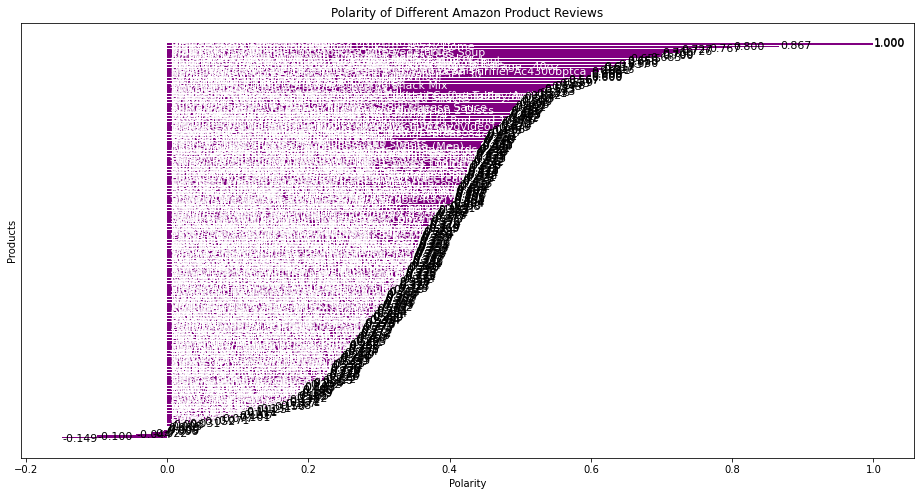

In [37]:
product_polarity_sorted=pd.DataFrame(df.groupby('name')['polarity'].mean().sort_values(ascending=True))

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Products')
plt.title('Polarity of Different Amazon Product Reviews')
polarity_graph=plt.barh(np.arange(len(product_polarity_sorted.index)),product_polarity_sorted['polarity'],color='purple',)

# Writing product names on bar
for bar,product in zip(polarity_graph,product_polarity_sorted.index):
  plt.text(0.005,bar.get_y()+bar.get_width(),'{}'.format(product),va='center',fontsize=11,color='white')

# Writing polarity values on graph
for bar,polarity in zip(polarity_graph,product_polarity_sorted['polarity']):
  plt.text(bar.get_width()+0.001,bar.get_y()+bar.get_width(),'%.3f'%polarity,va='center',fontsize=11,color='black')
  
plt.yticks([])
plt.show()


In [38]:
df.head()

,id,name,reviews_rating,reviews_username,user_sentiment,Reviews_Text_and_Title,cleaned,lemmatized,polarity
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,1,i love this album. it is very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy. Just Awesome,i love this album it is very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it rating all the way her metaphors are just crazy just awesome,love album good hip hop current pop sound hype listen everyday gym rate way metaphor crazy awesome,0.257143
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,Good flavor. This review was collected as part of a promotion. Good,good flavor this review was collected as part of a promotion good,good flavor review collect promotion good,0.700000
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,Good flavor. Good,good flavor good,good flavor good,0.700000
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca,0,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it did not even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I am disappointed that I paid as much as I did for a lube that I will not use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess. Disappointed",i read through the reviews on here before looking in to buying one of the couples lubricants and was ultimately disappointed that it did not even live up to the reviews i had read for starters neither my boyfriend nor i could notice any sort of enhanced or captivating sensation what we did notice however was the messy consistency that was reminiscent of a more liquidy vaseline it was difficult to clean up and was not a pleasant especially since it lacked the captivating sensation we had both been expecting i am disappointed that i paid as much as i did for a lube that i will not use again when i could just use their normal personal lubricant for less money and less mess disappointed,read review look buy couple lubricant ultimately disappointed live review read starter boyfriend notice sort enhanced captivating sensation notice messy consistency reminiscent liquidy vaseline difficult clean pleasant especially lack captivating sensation expect disappointed pay lube use use normal personal lubricant money mess disappoint,0.000812
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557,0,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I would not recommend this gel. Irritation,my husband bought this gel for us the gel caused irritation and it felt like it was burning my skin i would not recommend this gel irritation,husband buy gel gel cause irritation feel like burn skin recommend gel irritation,0.000000


In [39]:
## Dropping the columns which are not required
df_latest = df.drop(columns=['Reviews_Text_and_Title', 'cleaned','polarity'])

In [40]:
df_latest.head()

,id,name,reviews_rating,reviews_username,user_sentiment,lemmatized
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,1,love album good hip hop current pop sound hype listen everyday gym rate way metaphor crazy awesome
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,good flavor review collect promotion good
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,good flavor good
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca,0,read review look buy couple lubricant ultimately disappointed live review read starter boyfriend notice sort enhanced captivating sensation notice messy consistency reminiscent liquidy vaseline difficult clean pleasant especially lack captivating sensation expect disappointed pay lube use use normal personal lubricant money mess disappoint
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557,0,husband buy gel gel cause irritation feel like burn skin recommend gel irritation


In [41]:
df_latest.columns = ['id','name','reviews_rating','reviews_username','user_sentiment','Reviews_Text_and_Title']

In [42]:
df_latest.shape

(29936, 6)

In [43]:
df_latest.head()

,id,name,reviews_rating,reviews_username,user_sentiment,Reviews_Text_and_Title
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,1,love album good hip hop current pop sound hype listen everyday gym rate way metaphor crazy awesome
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,good flavor review collect promotion good
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,good flavor good
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca,0,read review look buy couple lubricant ultimately disappointed live review read starter boyfriend notice sort enhanced captivating sensation notice messy consistency reminiscent liquidy vaseline difficult clean pleasant especially lack captivating sensation expect disappointed pay lube use use normal personal lubricant money mess disappoint
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557,0,husband buy gel gel cause irritation feel like burn skin recommend gel irritation


In [44]:
# Save the preprocessed data for future use
pickle.dump(df_latest, open('processed_data.pkl', 'wb'))

# Feature Extraction

In [45]:
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer


x=df_latest['Reviews_Text_and_Title'] 
y=df_latest['user_sentiment']

## TF-IDF Vectorization

### Word Vectorization

In [46]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3))

# Model Building

## Train and Test Split

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.3,random_state=101)

In [48]:
#Shape of X_Train Y_Train 
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (20955,)
y_train (20955,)
X_test (8981,)
y_test (8981,)


## Class Imbalance check and method to handle it

In [49]:
df_latest['user_sentiment'].value_counts()

1    26579
0     3357
Name: user_sentiment, dtype: int64

### Clearly, a case of class imbalance. Hence, applying Random Over Sampler for handling this class imbalance

In [50]:
counter = Counter(y_train)
print("Before: ",counter)

sampling = over_sampling.RandomOverSampler(random_state=0)
X_train, y_train = sampling.fit_resample(pd.DataFrame(X_train), pd.Series(y_train))
X_train = pd.DataFrame(X_train).iloc[:,0].tolist()

counter = Counter(y_train)
print("After: ",counter)

Before:  Counter({1: 18629, 0: 2326})
After:  Counter({1: 18629, 0: 18629})


In [51]:
X_train_transformed = word_vectorizer.fit_transform(X_train)
X_test_transformed = word_vectorizer.transform(X_test.tolist())

## Utility Method
Functions to dispaly score, confusion matrix, calculating Sensitivity and Specificity

In [52]:
# Function to display 
def display_score(classifier):
    cm = confusion_matrix(y_test, classifier.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot() 
    print(classifier)
    print('Accuracy is ', accuracy_score(y_test, classifier.predict(X_test)))
    print('Sensitivity is {}'.format(cm[1][1]/sum(cm[1])))
    print('Specificity is {}'.format(cm[0][0]/sum(cm[0])))

In [53]:
#create a function for plotting confusion matrix

def cm_plot(cm_train,cm_test):
    print("Confusion matrix ")
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.heatmap(cm_train/np.sum(cm_train), annot=True , fmt = ' .2%',cmap="Greens")
    plt.subplot(1,2,2)
    sns.heatmap(cm_test/np.sum(cm_test), annot=True , fmt = ' .2%',cmap="Greens")
    plt.show()

In [54]:
#create a function for calculating Sensitivity and Specificity

def spec_sensitivity(cm_train,cm_test):
    
    #Train
    tn, fp, fn, tp = cm_train.ravel()
    specificity_train = tn / (tn+fp)
    sensitivity_train = tp / float(fn + tp)
    
    print("sensitivity for train set: ",sensitivity_train)
    print("specificity for train set: ",specificity_train)
    print("\n****\n")
    
    #Test
    tn, fp, fn, tp = cm_test.ravel()
    specificity_test = tn / (tn+fp)
    sensitivity_test = tp / float(fn + tp)
    
    print("sensitivity for test set: ",sensitivity_test)
    print("specificity for test set: ",specificity_test)

## Model 1 - Logistic Regression

In [55]:
logit=LogisticRegression()

logit.fit(X_train_transformed,y_train)


LogisticRegression()

In [56]:
y_train_pred_logit = logit.predict(X_train_transformed)

print("Logistic Regression train accuracy ", accuracy_score(y_train_pred_logit, y_train),"\n")
print(classification_report(y_train_pred_logit, y_train))

Logistic Regression train accuracy  0.988700413334049 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     18938
           1       0.98      1.00      0.99     18320

    accuracy                           0.99     37258
   macro avg       0.99      0.99      0.99     37258
weighted avg       0.99      0.99      0.99     37258



In [57]:
y_test_pred_logit = logit.predict(X_test_transformed)

print("Logistic Regression accuracy on test data", accuracy_score(y_test_pred_logit, y_test),"\n")
print(classification_report(y_test_pred_logit, y_test))

Logistic Regression accuracy on test data 0.8954459414319118 

              precision    recall  f1-score   support

           0       0.61      0.54      0.57      1176
           1       0.93      0.95      0.94      7805

    accuracy                           0.90      8981
   macro avg       0.77      0.74      0.76      8981
weighted avg       0.89      0.90      0.89      8981



In [58]:
cm_train = metrics.confusion_matrix(y_train, y_train_pred_logit)
cm_test = metrics.confusion_matrix(y_test, y_test_pred_logit)

In [59]:
spec_sensitivity(cm_train,cm_test)

sensitivity for train set:  0.9804068924794676
specificity for train set:  0.9969939341886306

****

sensitivity for test set:  0.9318238993710691
specificity for test set:  0.6149369544131911


Confusion matrix 


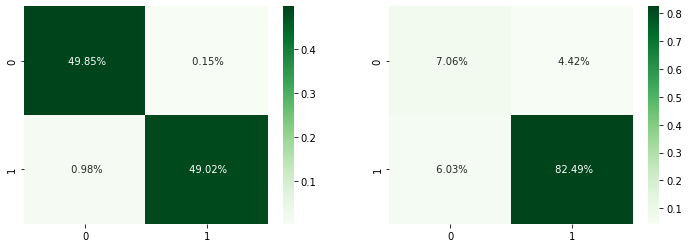

In [60]:
cm_plot(cm_train,cm_test)

## Model 2 - Random Forest Calssifier 

In [61]:
rf = RandomForestClassifier(n_estimators=50, random_state=101, n_jobs=-1)

rf.fit(X_train_transformed, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=101)

In [62]:
y_train_pred_rf = rf.predict(X_train_transformed)

print("Random Forest Classifier train accuracy", accuracy_score(y_train_pred_rf, y_train),"\n")
print(classification_report(y_train_pred_rf, y_train))

Random Forest Classifier train accuracy 0.9999731601266842 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18630
           1       1.00      1.00      1.00     18628

    accuracy                           1.00     37258
   macro avg       1.00      1.00      1.00     37258
weighted avg       1.00      1.00      1.00     37258



In [63]:
y_test_pred_rf = rf.predict(X_test_transformed)

print("Random Forest Classifier accuracy on test data", accuracy_score(y_test_pred_rf, y_test),"\n")
print(classification_report(y_test_pred_rf, y_test))

Random Forest Classifier accuracy on test data 0.906357866607282 

              precision    recall  f1-score   support

           0       0.31      0.71      0.43       442
           1       0.98      0.92      0.95      8539

    accuracy                           0.91      8981
   macro avg       0.65      0.82      0.69      8981
weighted avg       0.95      0.91      0.92      8981



In [64]:
cm_train_rf = metrics.confusion_matrix(y_train, y_train_pred_rf)
cm_test_rf = metrics.confusion_matrix(y_test, y_test_pred_rf)

In [65]:
spec_sensitivity(cm_train,cm_test)

sensitivity for train set:  0.9804068924794676
specificity for train set:  0.9969939341886306

****

sensitivity for test set:  0.9318238993710691
specificity for test set:  0.6149369544131911


Confusion matrix 


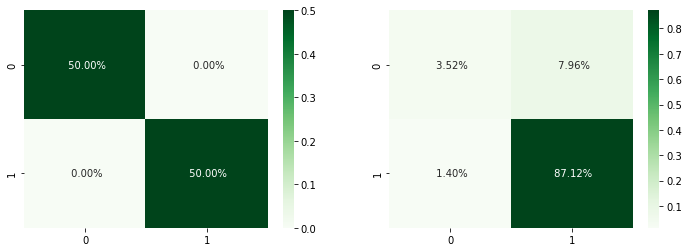

In [66]:
cm_plot(cm_train_rf,cm_test_rf)

## Model 3 - XG Boost 

In [67]:
xgb=xgb.XGBClassifier()

xgb.fit(X_train_transformed,y_train)

XGBClassifier()

In [68]:
y_train_pred_xgb = xgb.predict(X_train_transformed)

print("XG Boost train accuracy ", accuracy_score(y_train_pred_xgb, y_train),"\n")
print(classification_report(y_train_pred_xgb, y_train))

XG Boost train accuracy  0.8101347361640453 

              precision    recall  f1-score   support

           0       0.81      0.81      0.81     18623
           1       0.81      0.81      0.81     18635

    accuracy                           0.81     37258
   macro avg       0.81      0.81      0.81     37258
weighted avg       0.81      0.81      0.81     37258



In [69]:
y_test_pred_xgb = xgb.predict(X_test_transformed)

print("XG Boost accuracy on test data", accuracy_score(y_test_pred_xgb, y_test),"\n")
print(classification_report(y_test_pred_xgb, y_test))

XG Boost accuracy on test data 0.7698474557398953 

              precision    recall  f1-score   support

           0       0.80      0.31      0.44      2692
           1       0.77      0.97      0.85      6289

    accuracy                           0.77      8981
   macro avg       0.78      0.64      0.65      8981
weighted avg       0.78      0.77      0.73      8981



In [70]:
cm_train_xgb = metrics.confusion_matrix(y_train, y_train_pred_xgb)
cm_test_xgb = metrics.confusion_matrix(y_test, y_test_pred_xgb)

In [71]:
spec_sensitivity(cm_train_xgb,cm_test_xgb)

sensitivity for train set:  0.81029577540394
specificity for train set:  0.8099736969241506

****

sensitivity for test set:  0.7655345911949686
specificity for test set:  0.8031037827352085


Confusion matrix 


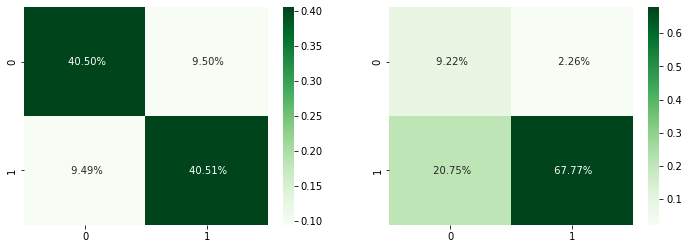

In [72]:
cm_plot(cm_train_xgb,cm_test_xgb)

## Model 4 - Naive Bayes 

In [73]:
nb = MultinomialNB()
nb.fit(X_train_transformed,y_train)

MultinomialNB()

In [74]:
y_train_pred_nb = nb.predict(X_train_transformed)

print("Naive Bayes train accuracy ", accuracy_score(y_train_pred_nb, y_train),"\n")
print(classification_report(y_train_pred_nb, y_train))

Naive Bayes train accuracy  0.9828761608245209 

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     19201
           1       0.97      1.00      0.98     18057

    accuracy                           0.98     37258
   macro avg       0.98      0.98      0.98     37258
weighted avg       0.98      0.98      0.98     37258



In [75]:
y_test_pred_nb = nb.predict(X_test_transformed)

print("Naive Bayes accuracy on test data", accuracy_score(y_test_pred_nb, y_test),"\n")
print(classification_report(y_test_pred_nb, y_test))

Naive Bayes accuracy on test data 0.8409976617303195 

              precision    recall  f1-score   support

           0       0.63      0.38      0.48      1699
           1       0.87      0.95      0.91      7282

    accuracy                           0.84      8981
   macro avg       0.75      0.67      0.69      8981
weighted avg       0.82      0.84      0.83      8981



In [76]:
cm_train_nb = metrics.confusion_matrix(y_train, y_train_pred_nb)
cm_test_nb = metrics.confusion_matrix(y_test, y_test_pred_nb)

In [77]:
spec_sensitivity(cm_train_nb,cm_test_nb)

sensitivity for train set:  0.9675237532878845
specificity for train set:  0.9982285683611574

****

sensitivity for test set:  0.8681761006289308
specificity for test set:  0.6314258001939864


Confusion matrix 


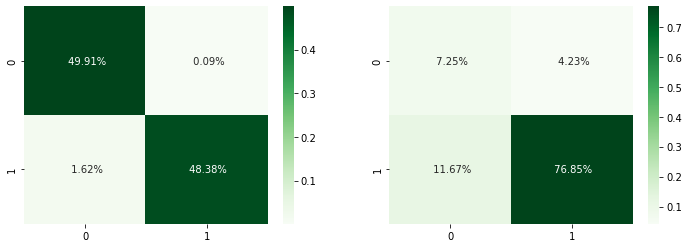

In [78]:
cm_plot(cm_train_nb,cm_test_nb)

## Conclusion
From the Results above the Logistic regression shows a better F1 score for macro Avg. Hence, selecting Logistic regression.

In [79]:
df_latest.columns

Index(['id', 'name', 'reviews_rating', 'reviews_username', 'user_sentiment',
       'Reviews_Text_and_Title'],
      dtype='object')

# Building The Recommendation System
Columns identified for recommendation system: reviews_username, id, reviews_rating

In [80]:
recommendation_df = df_latest[["name","reviews_username","reviews_rating"]]

recommendation_df.head()

,name,reviews_username,reviews_rating
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,K-Y Love Sensuality Pleasure Gel,walker557,1


In [81]:
recommendation_df.shape

(29936, 3)

In [82]:
recommendation_df.dtypes

name                object
reviews_username    object
reviews_rating       int64
dtype: object

In [83]:
recommendation_df.isnull().sum()

name                0
reviews_username    0
reviews_rating      0
dtype: int64

## Dividing the dataset into train and test

In [84]:
# Test and Train split of the dataset.
from sklearn.model_selection import train_test_split
train, test = train_test_split(recommendation_df, test_size=0.30, random_state=101)

In [85]:
print(train.shape)
print(test.shape)

(20955, 3)
(8981, 3)


In [86]:
train.head()

,name,reviews_username,reviews_rating
25787,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,youknowhowitgoes,5
11976,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,ruth,5
26913,Jason Aldean - They Don't Know,a1s3,5
2357,Mike Dave Need Wedding Dates (dvd + Digital),steph,5
1215,CeraVe SA Renewing Cream,thriftyshoppe,5


## USER - USER Based Recommendation System

In [87]:
# Pivot the train ratings' dataset into matrix format in which columns are products and the rows are user names.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(0)

In [88]:
df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [89]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [90]:
# The movies not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [91]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)

In [92]:
dummy_train.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


 ### Cosine Similarity

In [93]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.        0.        0.        ... 0.        0.        0.9486833]
 [0.        1.        1.        ... 0.        0.        0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        1.        0.       ]
 [0.        0.        0.        ... 1.        1.        0.       ]
 [0.9486833 0.        0.        ... 0.        0.        1.       ]]


In [94]:
user_correlation.shape

(18276, 18276)

### Adjusted Cosine
Here, we are not removing the NaN values and calculating the mean only for the movies rated by the use.

In [95]:
# Create a user-movie matrix.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)

In [96]:
df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalising the rating of the product for each user around 0 mean

In [97]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [98]:
df_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding cosine similarity

In [99]:
from sklearn.metrics.pairwise import pairwise_distances
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Prediction - User User

Going with the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

In [100]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset).


In [101]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))

In [102]:
user_predicted_ratings

array([[0.        , 0.55131785, 0.        , ..., 5.45578089, 2.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [103]:
user_predicted_ratings.shape

(18276, 251)

Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero.

In [104]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.551318,0.0,0.0,0.0,0.0,0.0,0.0,2.445695,0.0,...,0.0,1.154701,0.0,0.0,0.0,0.0,0.0,5.455781,2.0,0.0
01impala,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
02dakota,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
02deuce,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
06stidriver,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


  ### Evaluation - User User

Evaluation will be same as we have seen above for the prediction. The only difference being, we will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

In [105]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(2042, 3)

In [106]:
common.head()

,name,reviews_username,reviews_rating
15102,"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",marmar,5
17991,Vaseline Intensive Care Lip Therapy Cocoa Butter,asnyc,5
8980,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,afwifey2003,5
19963,Clorox Disinfecting Bathroom Cleaner,reenins,5
22092,"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",oldman,5


In [107]:
# convert into the user-movie matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username',
    columns='name',
    values='reviews_rating')

In [108]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [109]:
df_subtracted.head(1)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18266,18267,18268,18269,18270,18271,18272,18273,18274,18275
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
common.head(1)

,name,reviews_username,reviews_rating
15102,"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",marmar,5


In [112]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [113]:
user_correlation_df_1.shape

(1717, 18276)

In [114]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

user_correlation_df_3 = user_correlation_df_2.T

In [115]:
user_correlation_df_3.head()

,1234,1234567,1234asdf,1943,1witch,23jen,37f5p,4cloroxl,7inthenest,85lisa,...,xstr8edgex,yamel97,yoadrian,yshan,yucky111,yummy,yvonne,zapman,zitro,zmom
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,1.000000,0.0,0.0,0.288675,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.288675,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
user_correlation_df_3.shape

(1717, 1717)

In [117]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[1.66666667, 3.20936387, 0.        , ..., 0.        , 0.82019405,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [118]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username',
    columns='name',
    values='reviews_rating').fillna(0)

In [119]:
dummy_test.shape

(1717, 125)

In [120]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [121]:
common_user_predicted_ratings.head(2)

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,...,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculating the RMSE for only the Products rated by user. For RMSE, normalising the rating to (1,5) range.

In [122]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [123]:
common_ = common.pivot_table(index='reviews_username',
    columns='name',
    values='reviews_rating')

In [124]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [125]:
user_rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(user_rmse)

2.484586017752076


 ## ITEM -  ITEM Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different Product Id ID. In the user based similarity, we had taken mean for each user instead of each Product.

In [126]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1085,10ten,1143mom,...,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalising the Review rating for each Product for using the Adujsted Cosin

In [127]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [128]:
df_subtracted.head()

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1085,10ten,1143mom,...,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,0.296703,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding the cosine similarity using pairwise distances approach

In [129]:
from sklearn.metrics.pairwise import pairwise_distances

In [130]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


### Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [131]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Prediction Item-Item

In [132]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.03852762, 0.        , ..., 0.01753893, 0.        ,
        0.        ],
       [0.        , 0.00740503, 0.        , ..., 0.        , 0.        ,
        0.01050927],
       [0.        , 0.01234171, 0.        , ..., 0.        , 0.        ,
        0.01751545],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0419801 , 0.        , ..., 0.02243731, 0.        ,
        0.        ]])

In [133]:
item_predicted_ratings.shape

(18276, 251)

In [134]:
dummy_train.shape

(18276, 251)

### Filtering the rating only for the Products not rated by the user for recommendation

In [135]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.038528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.019846,0.0,0.000000,0.0,0.0,0.0,0.017539,0.0,0.000000
01impala,0.0,0.007405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.011564,0.0,0.004169,0.0,0.0,0.0,0.000000,0.0,0.010509
02dakota,0.0,0.012342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.019274,0.0,0.006949,0.0,0.0,0.0,0.000000,0.0,0.017515
02deuce,0.0,0.009873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.015419,0.0,0.005559,0.0,0.0,0.0,0.000000,0.0,0.014012
06stidriver,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000


### Evaluation - Item Item

Evaluation will be same as we have seen above for the prediction. The only difference being, we will evaluate for the Product already rated by the user insead of predicting it for the Product not rated by the user.

In [136]:
test.columns

Index(['name', 'reviews_username', 'reviews_rating'], dtype='object')

In [137]:
common =  test[test.name.isin(train.name)]
common.shape

(8957, 3)

In [138]:
common.head()

,name,reviews_username,reviews_rating
5549,100:Complete First Season (blu-Ray),jgraced93,5
2662,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),letsgobears,4
23071,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,primalm,3
3316,The Script - No Sound Without Silence (cd),arivalz,5
5107,The Resident Evil Collection 5 Discs (blu-Ray),dexterdurden,5


In [139]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [140]:
common_item_based_matrix.shape

(191, 8334)

In [141]:
item_correlation_df = pd.DataFrame(item_correlation)

In [142]:
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
list_name = common.name.tolist()

In [145]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [146]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [147]:
item_correlation_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,...,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Africa's Best No-Lye Dual Conditioning Relaxer System Super,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02146186, 0.        , 0.        , ..., 0.        , 0.00317873,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00278489,
        0.        ]])

In [149]:
common_item_predicted_ratings.shape

(191, 8334)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [150]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.

In [151]:
common = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [152]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [153]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [154]:
item_rmse = (sum(sum((common - y )**2))/total_non_nan)**0.5

In [155]:
print("ITEM Based Root Mean Square Error: ",item_rmse)

ITEM Based Root Mean Square Error:  3.5650002970721193


In [156]:
print("USER Based Root Mean Square Error: ",user_rmse)

USER Based Root Mean Square Error:  2.484586017752076


##Conclusion
Since User Based Recomendation System has less RMSE hence choosing User Based Recommendation system

# Recommendation of Top 20 Products to a Specified User

In [157]:
# Take the user ID as input.
user_input = "rebecca"

In [158]:
print(user_input)

rebecca


In [159]:
user_final_rating.head(2)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.551318,0.0,0.0,0.0,0.0,0.0,0.0,2.445695,0.0,...,0.0,1.154701,0.0,0.0,0.0,0.0,0.0,5.455781,2.0,0.0
01impala,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [160]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

name
Red (special Edition) (dvdvideo)                                                                 11.966155
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                                  11.858515
Clorox Disinfecting Bathroom Cleaner                                                              8.580869
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                                              6.942929
Power Crunch Protein Energy Bar Peanut Butter Creme Original                                      6.848063
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                               5.682880
Burt's Bees Lip Shimmer, Raisin                                                                   5.613543
Mike Dave Need Wedding Dates (dvd + Digital)                                                      5.407620
Chester's Cheese Flavored Puffcorn Snacks                                                         4.438799
Pendaflex174 Divide It Up File F

# Fine-Tuning the Recommendation System and Recommendation of Top 5 Products

In [161]:
# save the respective files and models through Pickle 
import pickle
pickle.dump(logit,open('logistic_model.pkl', 'wb'))
# loading pickle object
logit =  pickle.load(open('logistic_model.pkl', 'rb'))

pickle.dump(word_vectorizer,open('word_vectorizer.pkl','wb'))
# loading pickle object
word_vectorizer = pickle.load(open('word_vectorizer.pkl','rb'))

pickle.dump(user_final_rating,open('user_predicted_ratings.pkl','wb'))
user_predicted_ratings =  pickle.load(open('user_predicted_ratings.pkl', 'rb'))

## Function for Top 5 Recommended Products

In [162]:
def top_5_recommendation(user_input):
    arr = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]

    # Based on positive sentiment percentage.
    i= 0
    a = {}
    for prod_name in arr.index.tolist():
        product = prod_name
        product_name_review_list =df_latest[df_latest['name']== product]['Reviews_Text_and_Title'].tolist()
        features= word_vectorizer.transform(product_name_review_list)
        logit.predict(features)
        a[product] = logit.predict(features).mean()*100
    b= pd.Series(a).sort_values(ascending = False).head(5).index.tolist()
    print("Enter Username : ",user_input)
    print("Five Recommendations for you :")
    for i,val in enumerate(b):
        print(i+1,val)

In [163]:
top_5_recommendation(user_input)

Enter Username :  rebecca
Five Recommendations for you :
1 Red (special Edition) (dvdvideo)
2 My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)
3 Tresemme Kertatin Smooth Infusing Conditioning
4 Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)
5 Clorox Disinfecting Bathroom Cleaner


In [164]:
df_latest.to_csv("final_data.csv",index=False)

# Live app URL
App can be accessed online: https://maverick-product-recommender.herokuapp.com/